<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-programming/blob/main/Ch11_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11. 사전 학습 모델 활용하기

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype/font-awesome: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/opentype/mathjax: caching, new cache contents: 24 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/truetype/font-awesome: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/glyphico

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [ ]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 공통 함수 불러오기

In [ ]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


**사전 학습 모델**  
실제 업무에서 활용하는 딥러닝 모델은, 학습을 밑바닥부터 시작하는 경우는 오히려 드물고, 일반적으로 인터넷상에 공개된 사전 학습 모델을 사용해 효율적으로 학습하는 경우가 더 많다.  
사전 학습 모델 : 누군가에 의해 사전에 학습을 마친 모델. 공개된 모델들은 특정 태스크에 지나치게 치우치지 않고, 다방면으로 활용 가능하다고 판단 되는 시점에서 학습을 멈춘 모델이라 생각하는 것이 좋다.

## 11.2 사전 학습 모델

파이토치에서 이미지 분류 모델로 사용 가능한 사전 학습 모델  
https://pytorch.org/vision/0.8/models.html  
Top-1 에러 : 검증 데이터를 사용한 모델의 예측 결과와 정답이 일치하지 않은 비율  
Top-5 에러 : 정답이 모델의 예측 결과의 Top-5 안에 들지 못한 비율

In [ ]:
## 사전 학습 모델의 호출 예시
from torchvision import models
net = models.resnet18(pretrained=True)

## 11.3 Fine Tuning과 Transfer Learning

사전 학습 모델을 사용해서 효율적으로 학습하는 방법으로 'Fine Tuning'과 'Transfer Learning'을 들 수 있다.  
Fine Tuning이란, 사전 학습 모델의 파라미터를 초깃값으로 사용하지만, 모든 레이어 함수를 사용해 학습하는 방법이다.  
Transfer Learning이란, 사전 학습 모델의 파라미터 중에서 입력에 가까운 부분의 레이어 함수는 모두 고정하고, 출력에 가까운 부분만을 학습하는 방법이다.  
일반적으로 학습 데이터를 대량으로 확보하고 있을 때는 **Fine Tuning**, 그렇지 않은 경우는 **Transfer Learning**이 적합한 것으로 알려져 있다.

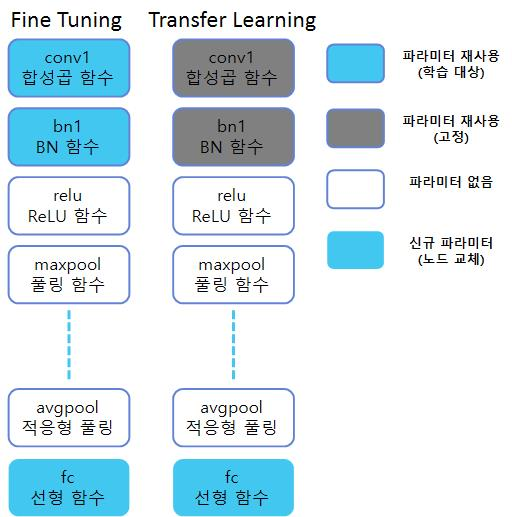

## 11.4 적응형 평균 풀링 함수(nn.AdaptiveAvgPool2d 함수)

적응형 평균 풀링 함수를 사용하면 이미지의 화소 수에 의존하지 않고도 이미지를 입력받을 수 있는 모델을 만들 수 있다.  
보통 pooling 함수에서 파라미터는 커널 사이즈(필터의 틀 사이즈)를 지정한다. 일반적으로 지정하는 (2, 2) 파라미터로 작성된 풀링 함수를 통과시키면, 해상도는 가로와 세로 모두 절반이 되었다.  
이에 반해 nn.AdaptiveXXXPool2d 함수에서 지정하는 파라미터는, 변환 후의 화소 수가 된다. nn.AdaptiveAvgPool2d((1,1))과 같이 호출하면 이 함수는 모든 채널의 결과를 1x1 화소로 한다는 의미를 갖는다. 어떤 연산을 통해 화소를 집약하는지는 XXX 안의 문자열을 통해 알 수 있다.  
따라서 AdaptiveAvgPool2d는 평균 값을 취하는 처리를 통해 채널의 결과를 1x1화소로 집약한다.

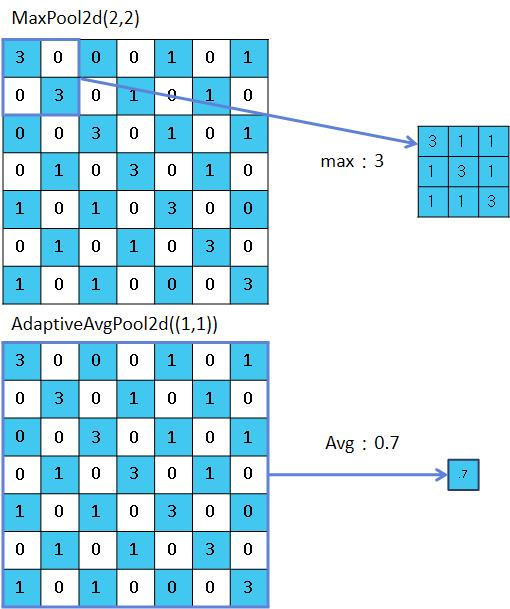

In [ ]:
# nn.AdaptiveAvgPool2d 정의
p = nn.AdaptiveAvgPool2d((1,1))
print(p)

# 선형 함수의 정의
l1 = nn.Linear(32, 10)
print(l1)

AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=32, out_features=10, bias=True)


In [ ]:
# 사전 학습 모델 시뮬레이션
inputs = torch.randn(100, 32, 16, 16)
m1 = p(inputs)
m2 = m1.view(m1.shape[0],-1)
m3 = l1(m2)

# shape 확인
print(m1.shape)
print(m2.shape)
print(m3.shape)

torch.Size([100, 32, 1, 1])
torch.Size([100, 32])
torch.Size([100, 10])


이런 구조라면 inputs의 shape이 [100, 32, 8, 8]이나 [100, 32, 4, 4]라 할지라도 동일한 선형 함수 Linear(32,10)을 사용할 수 있다

CNN 모델을 작성할 때, 첫번째 선형 함수의 입력 차원수를 어떤 방식으로든지 계산해야 할 필요가 있었는데, 합성곱 처리의 마지막 단계에 적응형 평균 풀링 함수를 사용하면 해결된다. 이와 같은 이유로 사전 학습 모델이 입력 화소 수에 상관없이 사용할 수 있는 것이다.  
하지만, ResNet-18과 VGG-19-BN은 모두 가로세로 224화소의 이미지로 학습된 모델이므로, 학습할 때는 될 수 있으면 입력 데이터 화소 수를 그 값에 맞추는 것이 정확도 향상의 관점에서 바람직하다.

## 11.5 데이터 준비

In [ ]:
# 분류 클래스명 정의

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 분류 클래스 수는 10
n_output = len(classes)

In [ ]:
# Transforms 정의

# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
  transforms.Resize(112), ## 원본 이미지를 지정된 화수 소(112)로 확대 또는 축소. 데이터를 확대하면 모델의 정확도가 높아진 실험의 결과 반영
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
  transforms.Resize(112),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [ ]:
# 데이터 취득용 함수 dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# 배치 사이즈 지정
batch_size = 50 ## batch_size = 100으로 지정하면 GPU 메모리가 부족해짐

# 데이터로더

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정함
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용은 셔플이 필요하지 않음
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

## 11.6 ResNet-18 불러오기

In [ ]:
#  라이브러리 임포트
from torchvision import models

# 사전 학습 모델 불러오기
# pretraind = True로 학습을 마친 파라미터를 동시에 불러오기
net = models.resnet18(pretrained = True)

In [ ]:
# 모델 개요 표시 1
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델 개요 표시 2
net = net.to(device)
summary(net,(100,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 1000]               --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

In [ ]:
print(net.fc)
print(net.fc.in_features)
## fc는 선형 함수(nn.Linear)이며, 입력(in_features)은 512, 출력(out_features)은 100이다.

Linear(in_features=512, out_features=1000, bias=True)
512


## 11.7 최종 레이어 함수 교체하기

**최종 레이어 함수 교체**  
모델을 불러온 직후의 사전 학습 모델은, 학습 당시에 1,000 종류에 달하는 클래스를 분류하는 태스크를 목표하고 있었기 때문에, 가장 마지막 단의 선형 함수의 출력은 1,000 차원으로 설정돼 있다.  
그러나 이번에 사용하는 CIFAR-10은 10종류의 클래스를 분류하는 것을 목적으로 하는 데이터셋이므로, 출력은 10차원이어야 한다.  
Fine Tuning이든 Transfer Learning이든, 불러온 사전 학습 모델의 마지막 단을 목적에 맞는 선형 함수로 교체해야 한다.

In [ ]:
# 난수 고정
torch_seed()

# 최종 레이어 함수의 입력 차원수 확인
fc_in_features = net.fc.in_features

# 최종 레이어 함수 교체
net.fc = nn.Linear(fc_in_features, n_output)

In [ ]:
# 모델 개요 표시 1
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델 개요 표시 2

net = net.to(device)
summary(net,(100,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 10]                 --
├─Conv2d: 1-1                            [100, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [100, 64, 112, 112]       128
├─ReLU: 1-3                              [100, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [100, 64, 56, 56]         --
├─Sequential: 1-5                        [100, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [100, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [100, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [100, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [100, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [100, 64, 56, 56]         --
│

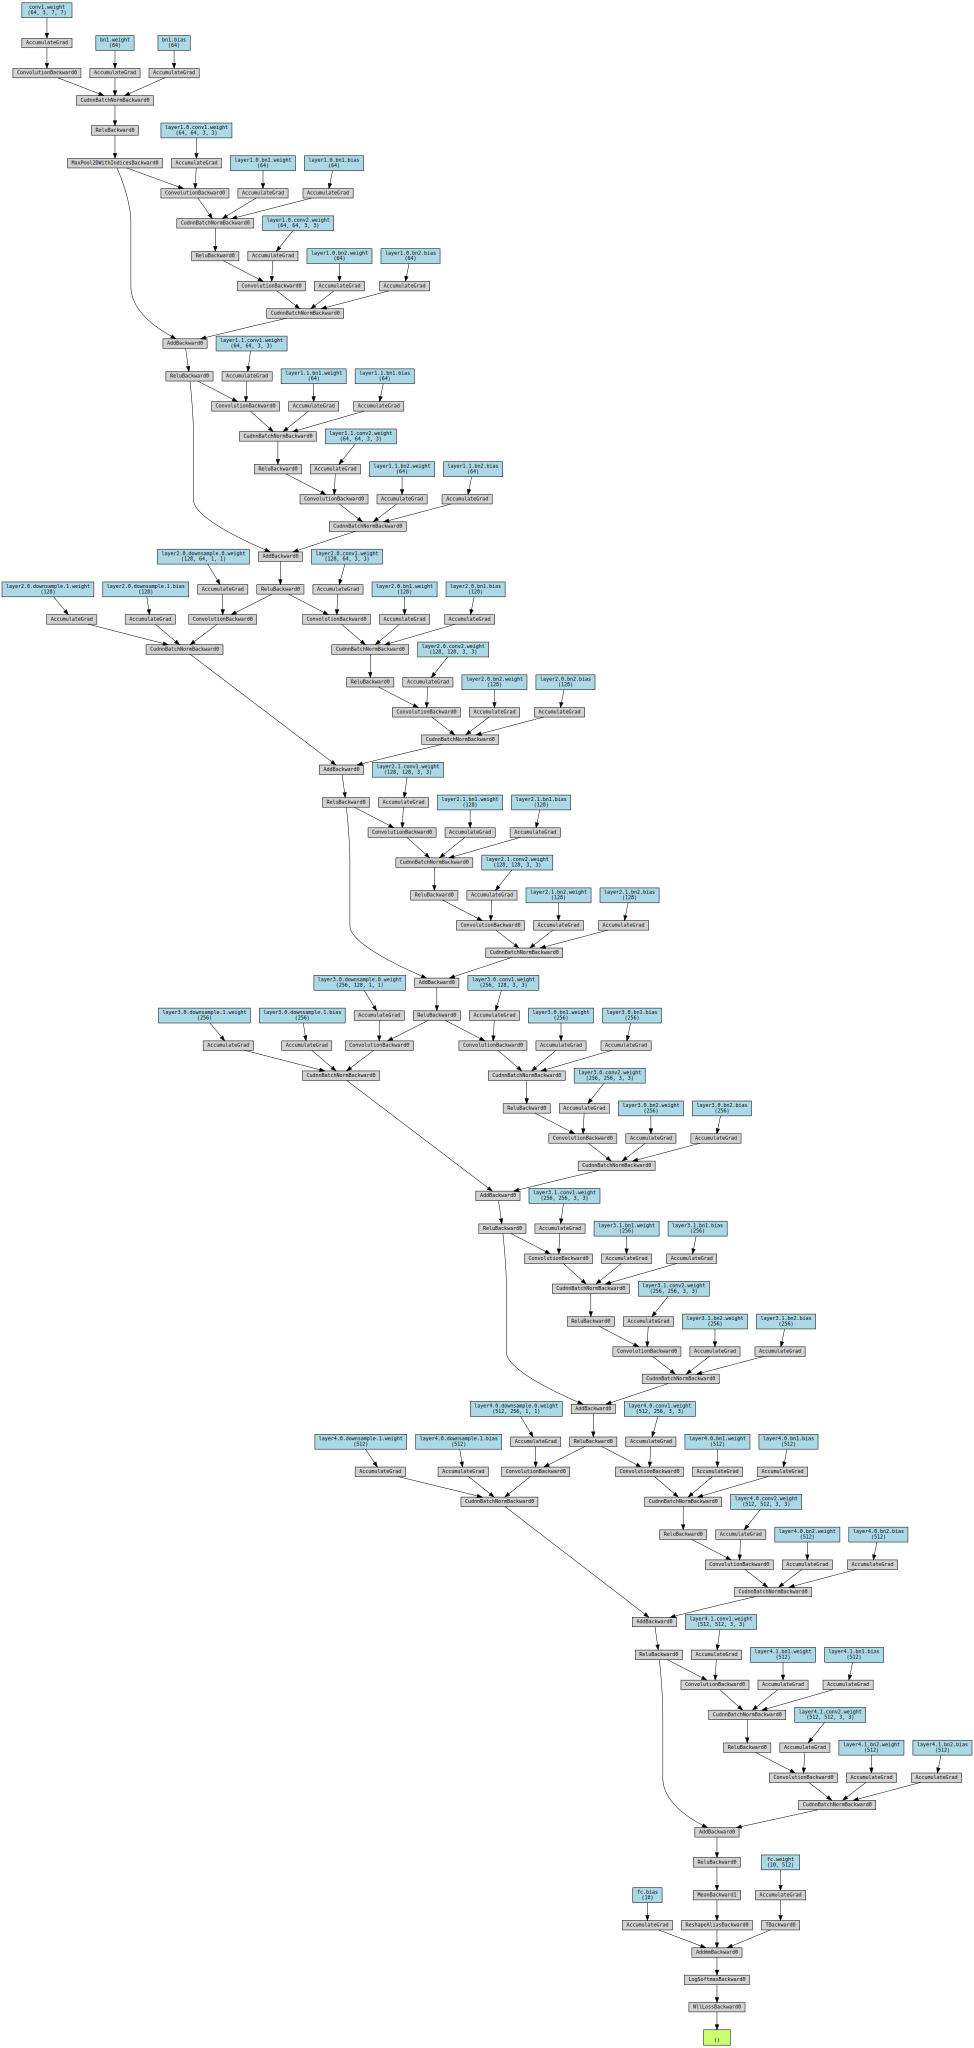

In [ ]:
# 손실 계산 그래프 시각화

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 11.8 학습과 결과 평가

### 초기 설정

In [ ]:
# 난수 고정
torch_seed()

# 사전 학습 모델 불러오기
# pretraind = True로 학습을 마친 파라미터도 함께 불러오기
net = models.resnet18(pretrained = True)

# 최종 레이어 함수 입력 차원수 확인
fc_in_features = net.fc.in_features

# 최종 레이어 함수 교체
net.fc = nn.Linear(fc_in_features, n_output)

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# history 파일 초기화
history = np.zeros((0, 5))

가장 효율적인 최적화 함수는 일반적으로 **Adam**으로 알려져 있다. 완전히 초기 상태부터 학습을 진행하는 경우라면 그렇지만, 사전 학습 모델을 사용한다면 각 레이어 함수의 파라미터는 어느 정도 최적화가 이뤄진 상태이다.  
이런 조건에서 학습한다면, 복잡한 최적화 함수를 사용하기보다, 비교적 간단한 알고리즘을 사용하는 것이 좋다고 알려져 있다.  
따라서 **momentum 옵션을 추가한 optim.SGD** 함수를 최적화 함수로 사용한다.

### 학습

In [ ]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs,
        train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.01207 acc: 0.79278 val_loss: 0.00514, val_acc: 0.91150


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00640 acc: 0.88906 val_loss: 0.00423, val_acc: 0.92650


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00512 acc: 0.91222 val_loss: 0.00386, val_acc: 0.93500


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00437 acc: 0.92306 val_loss: 0.00344, val_acc: 0.94090


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00383 acc: 0.93446 val_loss: 0.00354, val_acc: 0.94190


### 학습 결과 평가

초기상태 : 손실 : 0.00514  정확도 : 0.91150
최종상태 : 손실 : 0.00354 정확도 : 0.94190


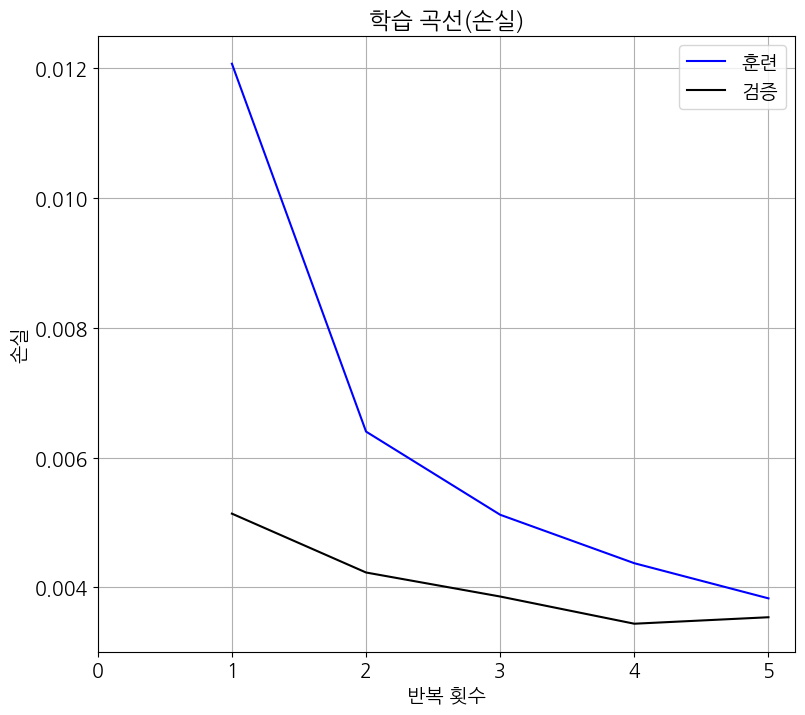

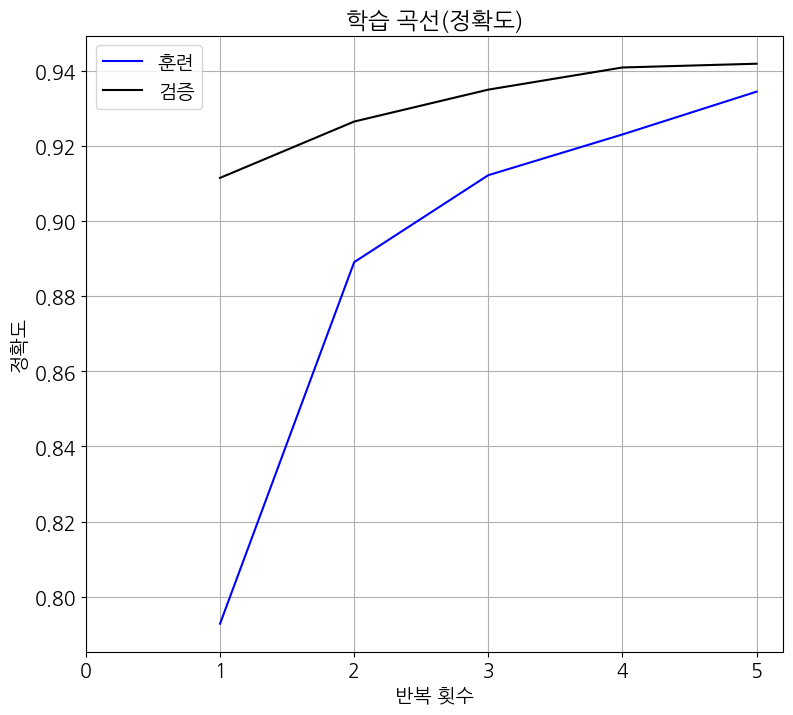

In [ ]:
# 결과 요약
evaluate_history(history)

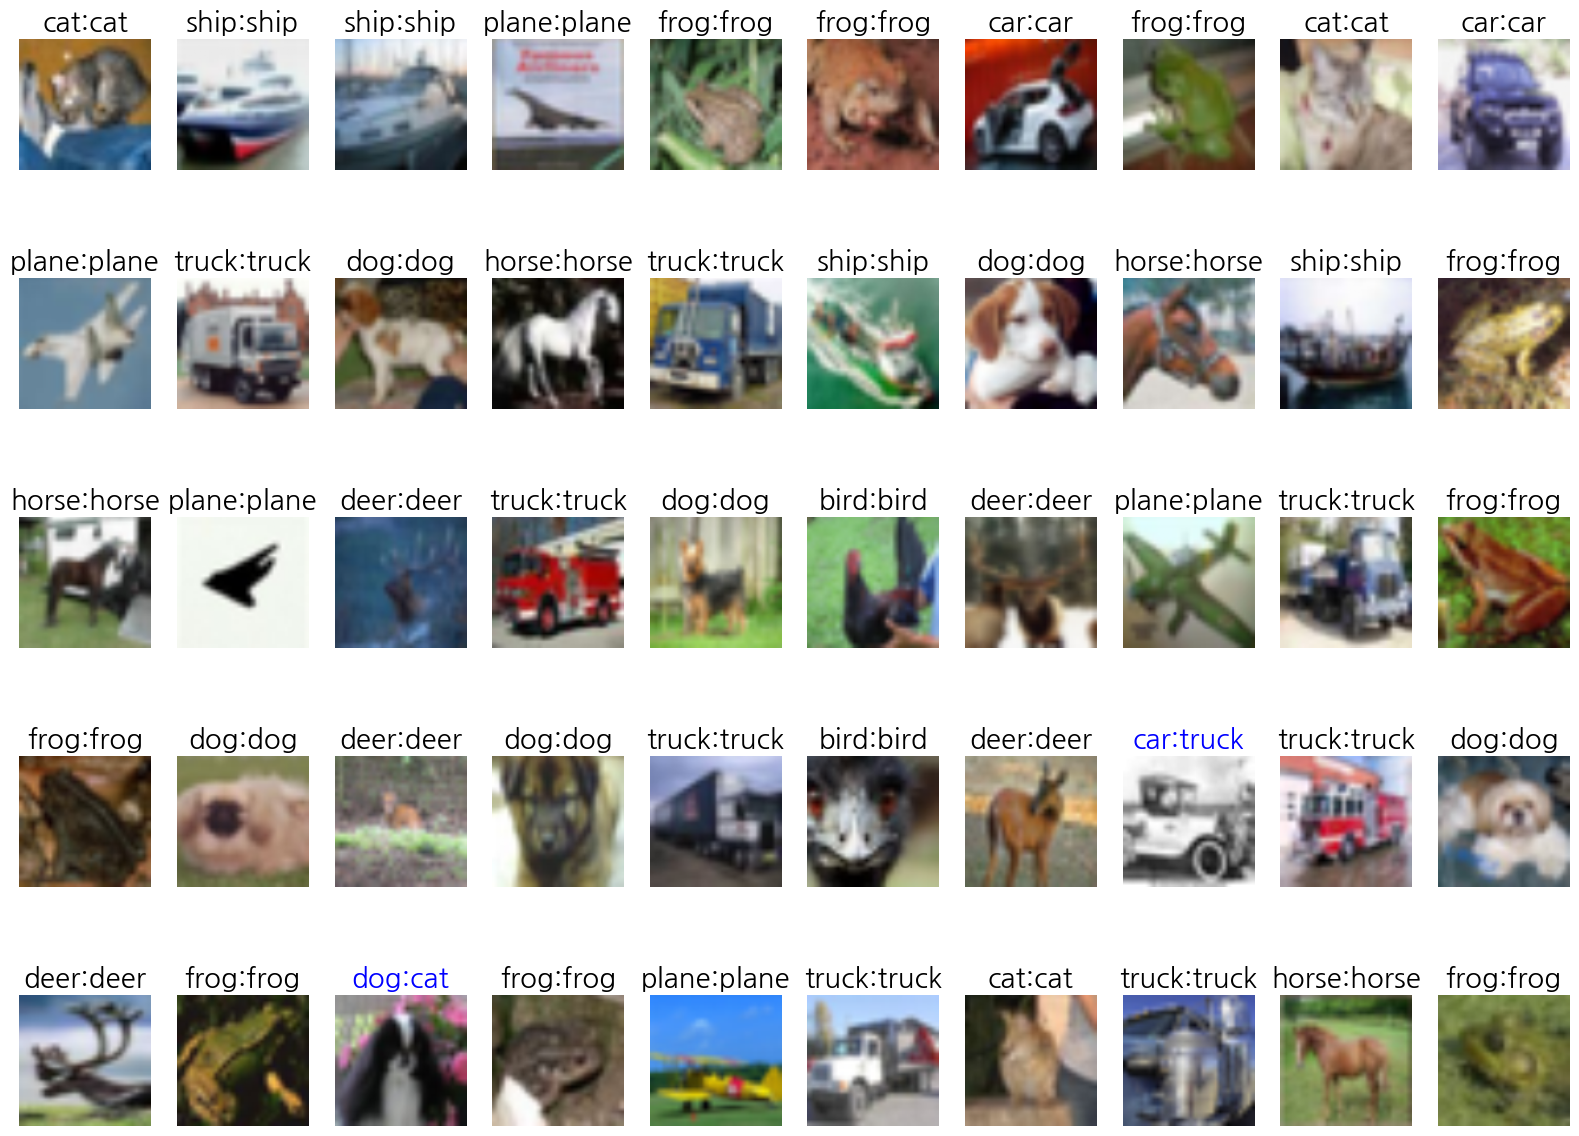

In [ ]:
# 이미지와 정답, 예측 결과를 함께 표시
show_images_labels(test_loader, classes, net, device)

## 11.9 VGG-19-BN 활용하기

### 모델 불러오기

In [ ]:
# 사전 학습 모델 불러오기
from torchvision import models
net = models.vgg19_bn(pretrained = True)

### 모델 구조 확인

In [ ]:
# 모델 개요 표시 1
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

최종 레이어 함수는 `classifier[6]` 임을 알 수 있다.

In [ ]:
# 최종 레이어 함수 확인
print(net.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


### 최종 레이어 함수 교체

In [ ]:
# 난수 고정
torch_seed()

# 최종 레이어 함수 교체
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

## 아래 두줄은 노드 교체보단 모델의 정확도를 재현하기 위해 필요한 처리

# features 마지막의 MaxPool2d 제거
net.features = net.features[:-1]

# AdaptiveAvgPool2d 제거
net.avgpool = nn.Identity()

In [ ]:
# 모델 개요 표시 2
net = net.to(device)
summary(net,(100,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [100, 64, 112, 112]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 112, 112]       128
│    └─ReLU: 2-3                         [100, 64, 112, 112]       --
│    └─Conv2d: 2-4                       [100, 64, 112, 112]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 112, 112]       128
│    └─ReLU: 2-6                         [100, 64, 112, 112]       --
│    └─MaxPool2d: 2-7                    [100, 64, 56, 56]         --
│    └─Conv2d: 2-8                       [100, 128, 56, 56]        73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 56, 56]        256
│    └─ReLU: 2-10                        [100, 128, 56, 56]        --
│    └─Conv2d: 2-11                      [100, 128, 56, 56]        147,

## 손실 계산 그래프 시각화

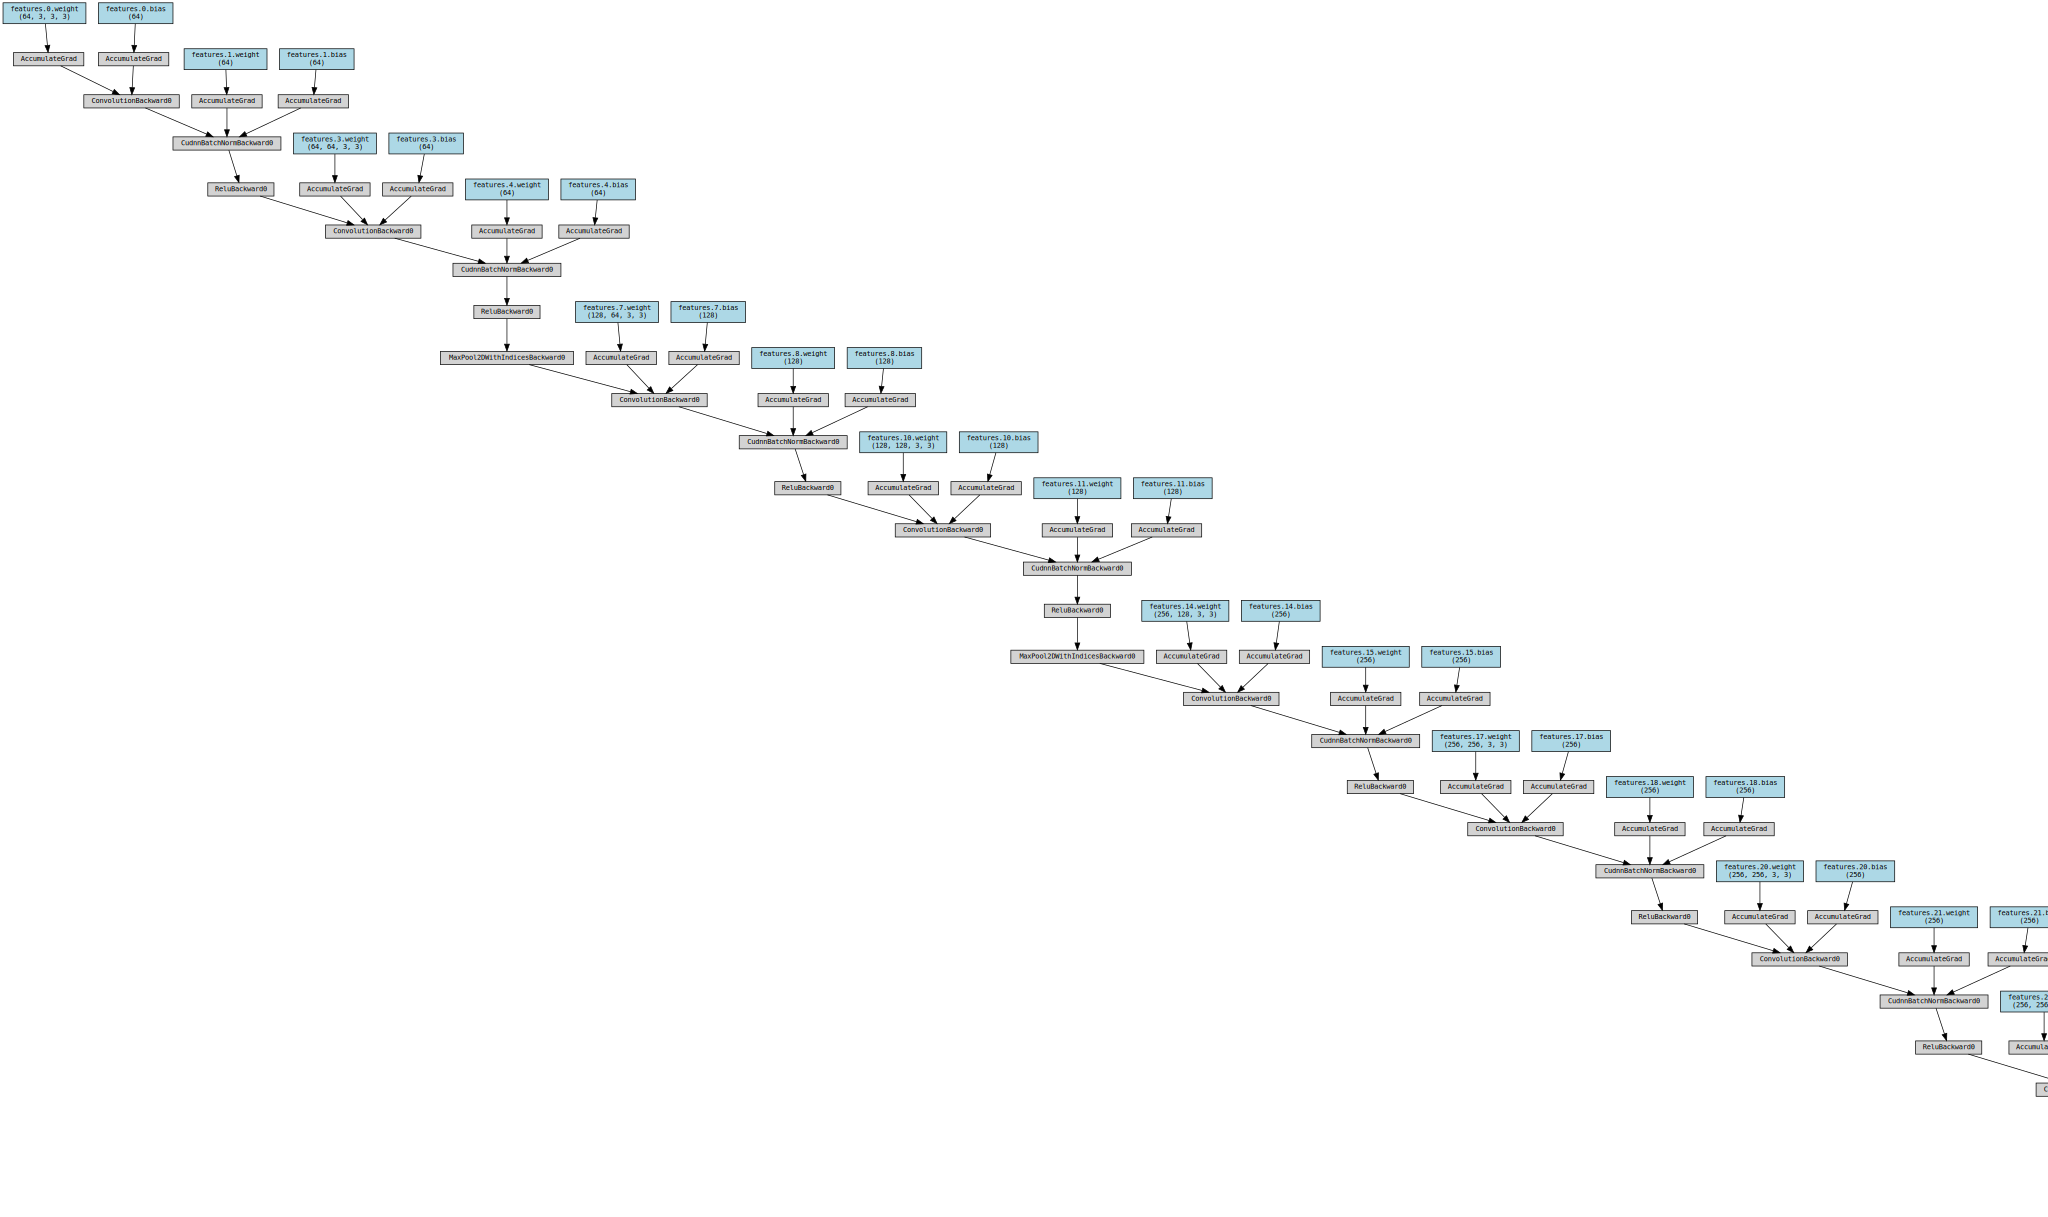

In [ ]:
# 손실 계산 그래프 시각화

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 초기 설정

In [ ]:
# 난수 고정
torch_seed()

# 사전 학습 모델 불러오기
net = models.vgg19_bn(pretrained = True)

# 최종 레이어 함수 교체
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

# features 마지막의 MaxPool2d 제거
net.features = net.features[:-1]

# AdaptiveAvgPool2d 제거
net.avgpool = nn.Identity()

# 모델을 GPU로 전송
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# history 초기화
history = np.zeros((0, 5))

### 학습

In [ ]:
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.00990 acc: 0.83184 val_loss: 0.00379, val_acc: 0.93460


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00478 acc: 0.91788 val_loss: 0.00309, val_acc: 0.94660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00367 acc: 0.93788 val_loss: 0.00264, val_acc: 0.95500


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00307 acc: 0.94722 val_loss: 0.00267, val_acc: 0.95550


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00263 acc: 0.95582 val_loss: 0.00252, val_acc: 0.95700


### 결과 확인

초기상태 : 손실 : 0.00379  정확도 : 0.93460
최종상태 : 손실 : 0.00252 정확도 : 0.95700


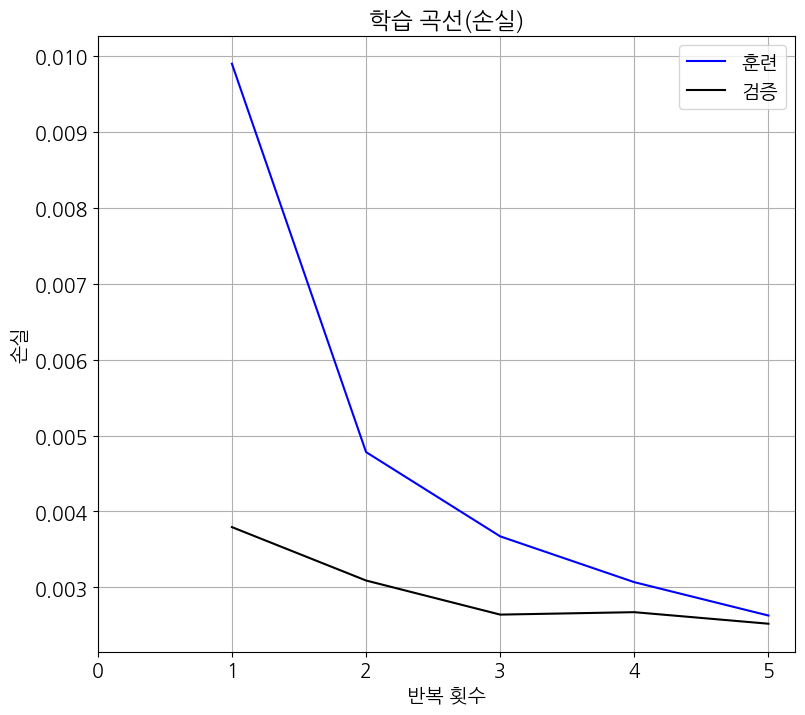

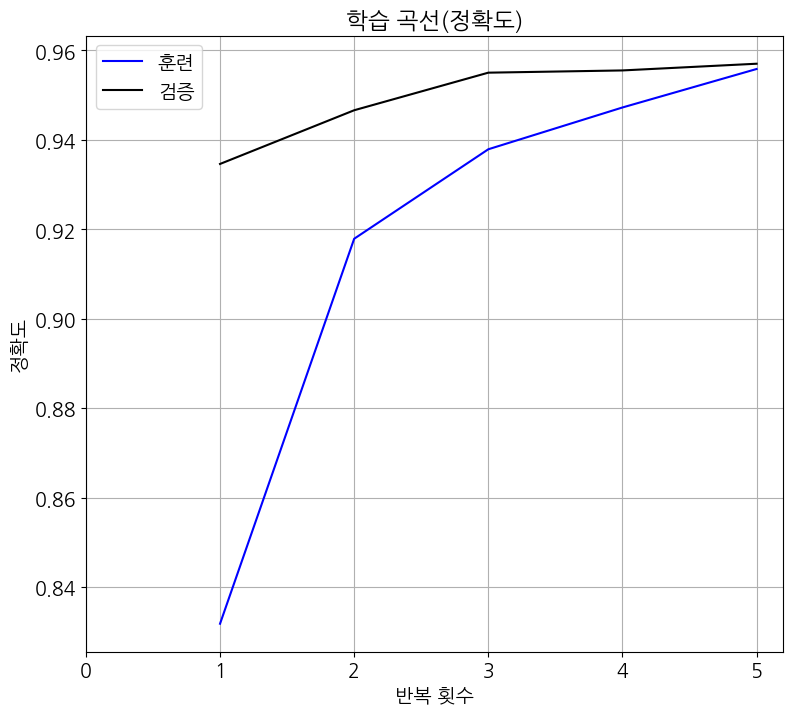

In [ ]:
# 결과 요약
evaluate_history(history)

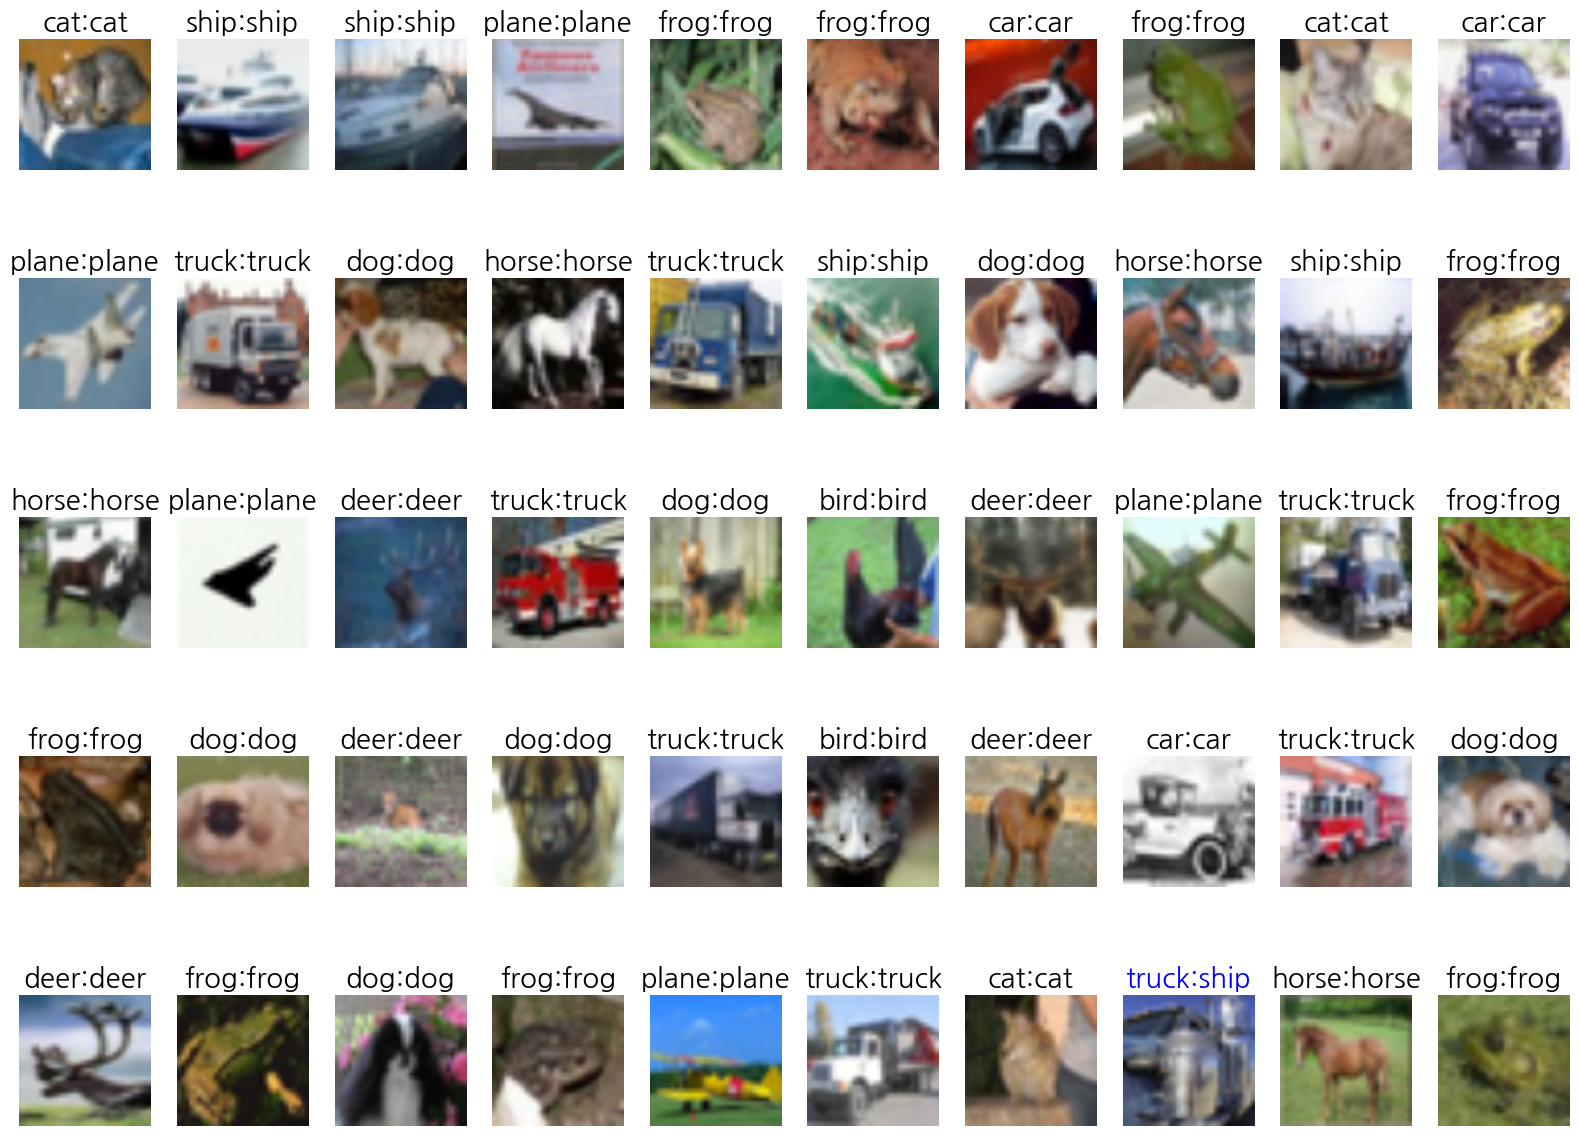

In [ ]:
# 이미지와 정답, 예측 결과를 함께 표시
show_images_labels(test_loader, classes, net, device)

## 칼럼 재현성을 보장하는 머신러닝 모델을 작성하는 법  
torch_seed 함수의 목적과 그 의미

In [ ]:
# 파이토치 난수 고정
def torch_seed(seed=123):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.use_deterministic_algorithms = True

**머신러닝과 난수의 관계**  
머신러닝, 딥러닝에서 다루는 알고리즘에는 난수가 필요한 처리가 몇가지 있다.  
- 파라미터 초기화 : 선형 함수 등의 파라미터는 초깃값을 설정하기 위해 난수를 사용한다.  
- 데이터로더 : 데이터로더에서 shuffle=True로 설정하면, 어떤 학습 데이터를 선택할지를 난수를 통해 결정한다
- 드롭아웃 : 드롭아웃 함수는 알고리즘 그 자체에 난수가 필요하다.
- 데이터 증강 : 훈련 데이터를 가공할 때 난수를 사용한다.  

## 칼럼 범용적인 사전 학습 모델을 작성하는 법  
VGG=19-BN 모델을 사용함에 있어, features의 마지막의 MaxPool2d를 제거하고, AdaptiveAvgPool2d를 제거하는 이유에 대해 설명한다

In [ ]:
# features 마지막의 MaxPool2d 제거
net.features = net.features[:-1]

# AdaptiveAvgPool2d 제거
net.avgpool = nn.Identity()

이 두 줄의 코드의 목적은 정확도가 같은 결과에 관해서 재현성을 보장하는 모델을 만드는 것이지만, 사전 학습 모델로 전이 학습을 한 모델을 다른 플랫폼으로 배포(deploy)해서 예측하는 것에도 도움이 된다.  
다른 플랫폼에서 사용 가능한 모델의 표준 형식으로는 'ONNX'를 들 수 있다. 사실 파이토치 본연의 VGG-19-BN 모델을 ONNX로 export 하면 에러가 발생한다. 그 이유는, AdaptiveAvgPool2d 함수가 ONNX로 export 되지 않기 때문이다. 모델에서 AdaptiveAvgPool2d 함수를 삭제한다면, 모델을 export할 수 있게 된다.

In [ ]:
net = models.vgg19_bn(pretrained = True)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### 중간 텐서 확인

In [ ]:
# 원본 데이터 사이즈의 경우(배치사이즈 100)
net = net.to(device)
summary(net, (100, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [100, 1000]               --
├─Sequential: 1-1                        [100, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [100, 64, 224, 224]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 224, 224]       128
│    └─ReLU: 2-3                         [100, 64, 224, 224]       --
│    └─Conv2d: 2-4                       [100, 64, 224, 224]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 224, 224]       128
│    └─ReLU: 2-6                         [100, 64, 224, 224]       --
│    └─MaxPool2d: 2-7                    [100, 64, 112, 112]       --
│    └─Conv2d: 2-8                       [100, 128, 112, 112]      73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 112, 112]      256
│    └─ReLU: 2-10                        [100, 128, 112, 112]      --
│    └─Conv2d: 2-11                      [100, 128, 112, 112]      147,

AdaptiveAvgPool2d 레이어 함수 부분의 데이터 shape에 변화가 없다.  
이는 (3,224,224) 사이지를 가진 입력 텐서인 경우 아무것도 처리하지 않음을 알 수 있다.

In [ ]:
# 실습용 데이터 사이즈의 경우(배치사이즈 100)
summary(net, (100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [100, 1000]               --
├─Sequential: 1-1                        [100, 512, 3, 3]          --
│    └─Conv2d: 2-1                       [100, 64, 112, 112]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 112, 112]       128
│    └─ReLU: 2-3                         [100, 64, 112, 112]       --
│    └─Conv2d: 2-4                       [100, 64, 112, 112]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 112, 112]       128
│    └─ReLU: 2-6                         [100, 64, 112, 112]       --
│    └─MaxPool2d: 2-7                    [100, 64, 56, 56]         --
│    └─Conv2d: 2-8                       [100, 128, 56, 56]        73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 56, 56]        256
│    └─ReLU: 2-10                        [100, 128, 56, 56]        --
│    └─Conv2d: 2-11                      [100, 128, 56, 56]        147,

ReLU-52를 거칠 때 이미 [100,512,7,7] 사이즈의 텐서로 변했는데, 그 다음의 MaxPool2d-53에서 [100,512,3,3] 사이즈로 변경되었다가, AdaptiveAvgPool2d에서 다시 [100,512,7,7]로 사이즈가 되돌아왔다.  
다시 말해, 두 레이어 함수 MaxPool2d-53과 AdaptiveAvgPool2d를 동시에 없애고, ReLU-52의 출력을 직접 Linear-55로 이을 수만 있다면, 첫 번째 선형 함수의 사이즈 문제에 영향을 끼치지 않고, AdaptiveAvgPool2d 함수가 없는 사전 학습 모델을 사용할 수 있게 된다.

### MaxPool2d-53 제거

In [ ]:
# 난수 고정
torch_seed()

# 최종 레이어 함수 교체
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

In [ ]:
# features의 마지막 요소(MaxPool2d)를 제거
net.features = net.features[:-1]
print(net.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

### AdaptiveAvgPool2d-54 제거

원래 모델에서는 forward 함수 내부에서 avgpool 함수를 호출할 것으로 예상되므로 이 부분은 제거할 수 없다.  
따라서, AdaptiveAvgPool2d가 위치한 부분을 아무것도 하지 않는 함수로 치환해서 마치 동일한 처리를 하는 것처럼 생각할 수 있다.  
아무것도 하지 않는 함수란, 파이토치에서 nn.Identify 함수이다.

In [ ]:
# avgpool에 위치한AdaptiveAvgPool2d을 아무것도 하지 않는 함수(nn.Identity)로 치환
net.avgpool = nn.Identity()

### 결과 확인

In [ ]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# 실습용 데이터 사이즈로 중간 텐서 확인(배치사이즈 100)
net = net.to(device)
summary(net,(100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [100, 64, 112, 112]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 112, 112]       128
│    └─ReLU: 2-3                         [100, 64, 112, 112]       --
│    └─Conv2d: 2-4                       [100, 64, 112, 112]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 112, 112]       128
│    └─ReLU: 2-6                         [100, 64, 112, 112]       --
│    └─MaxPool2d: 2-7                    [100, 64, 56, 56]         --
│    └─Conv2d: 2-8                       [100, 128, 56, 56]        73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 56, 56]        256
│    └─ReLU: 2-10                        [100, 128, 56, 56]        --
│    └─Conv2d: 2-11                      [100, 128, 56, 56]        147,

ReLU: 2-52의 출력인 [100, 412, 7, 7] 사이즈의 텐서가 아무것도 하지 않는 Identity: 1-2 함수를 거쳐 Linear: 2-53 함수로 직접 입력되고 있다.